In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
!unzip /kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip
!unzip /kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
!unzip /kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip

Archive:  /kaggle/input/web-traffic-time-series-forecasting/train_1.csv.zip
  inflating: train_1.csv             
Archive:  /kaggle/input/web-traffic-time-series-forecasting/key_1.csv.zip
  inflating: key_1.csv               
Archive:  /kaggle/input/web-traffic-time-series-forecasting/sample_submission_1.csv.zip
  inflating: sample_submission_1.csv  


In [3]:
train = pd.read_csv("/kaggle/working/train_1.csv")
key = pd.read_csv("/kaggle/working/key_1.csv")
sample = pd.read_csv("/kaggle/working/sample_submission_1.csv")

In [4]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)



## Data Cleanning & Analysis

In [5]:
def get_date(s):
    return s[-10:]
def get_site(s):
    return s[:-11]
key['Date'] = pd.to_datetime(key.Page.apply(get_date))
key['Page'] = key.Page.apply(get_site)

In [6]:
train.fillna(0)
train = pd.melt(train,id_vars=['Page'],var_name='Date',value_name='Visits').fillna(0)

In [7]:
filtre = train[train['Page'] == 'Roman_Herzog_de.wikipedia.org_all-access_spider']
#filtre['Date'] = pd.DatetimeIndex(filtre['Date'])
filtre.set_index('Date', inplace = True)
filtre.drop(columns = ['Page'], inplace = True)

/tmp/ipykernel_21/1745637366.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtre.drop(columns = ['Page'], inplace = True)


## Model Selection

In [8]:
trend = filtre.rolling(
    window=30, 
    center=True,    
    min_periods=15,  
).mean()              

In [9]:
y = pd.Series(filtre.Visits, index = np.array(filtre.index))
dp = DeterministicProcess(
    index=y.index, 
    constant=False,       
    order=1,             
    drop=True,           
)

X = dp.in_sample()
X_fore = dp.out_of_sample(steps=60)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


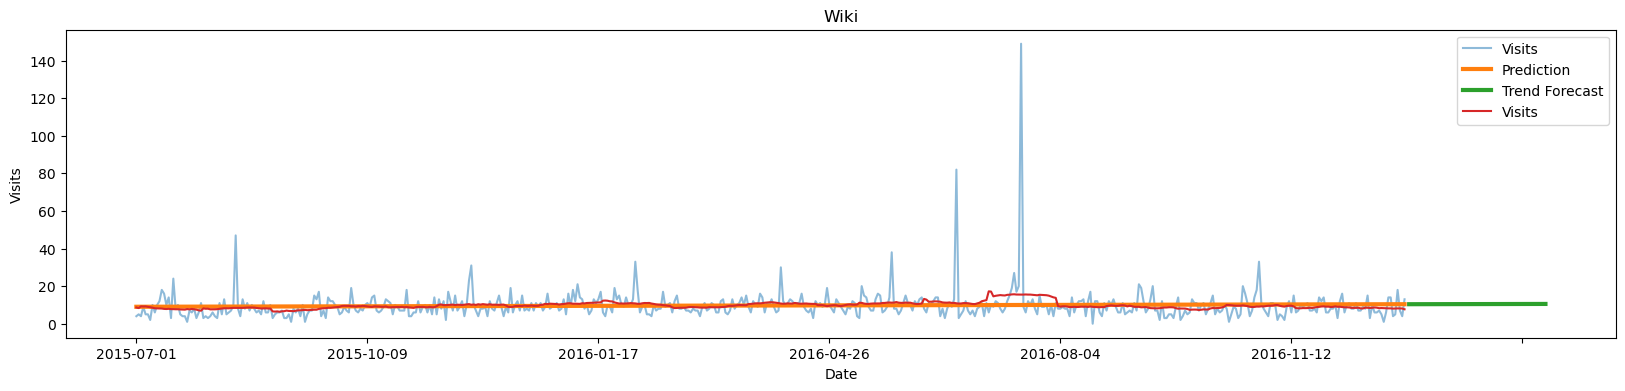

In [10]:
ax = plt.figure(figsize=(20,4))
ax = y.plot(alpha=0.5, title="Wiki", ylabel="Visits")
ax = y_pred.plot(ax=ax, linewidth=3, label="Prediction")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast")
ax = trend.plot(ax = ax,label="MA")
ax.legend();

In [11]:
trend_error = mse(y,y_pred)

### Seasonality
- Using 20 order fourier Series to model seasonality

/tmp/ipykernel_21/3621096864.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  X["week"] = X.index.week
/tmp/ipykernel_21/791420120.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
/tmp/ipykernel_21/791420120.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


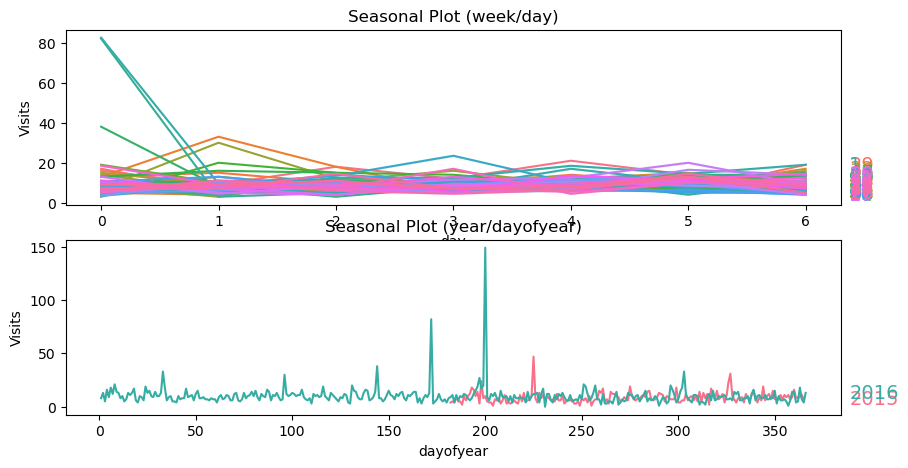

In [12]:
X = filtre.copy()
X.index = pd.to_datetime(X.index)
X["day"] = X.index.dayofweek 
X["week"] = X.index.week 
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 5))
seasonal_plot(X, y="Visits", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="Visits", period="year", freq="dayofyear", ax=ax1);

<Axes: xlabel='day', ylabel='Visits'>

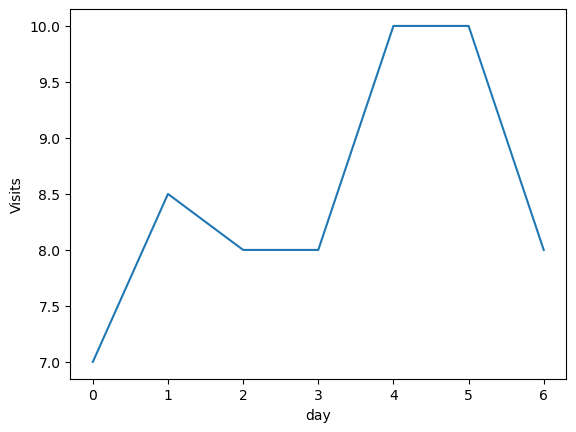

In [13]:
sns.lineplot(X.groupby('day').median()['Visits'])

/tmp/ipykernel_21/791420120.py:31: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


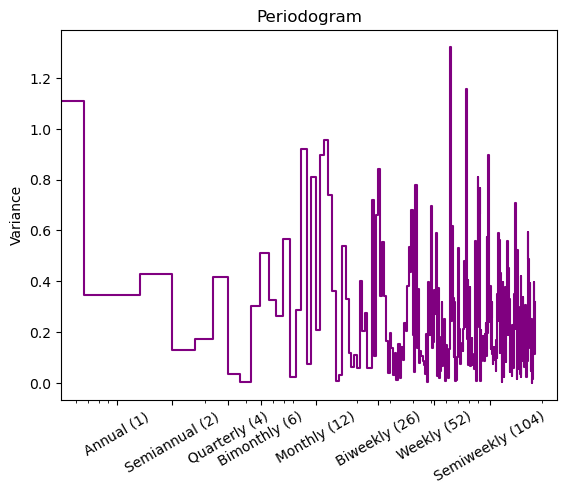

In [14]:
plot_periodogram(X.Visits);

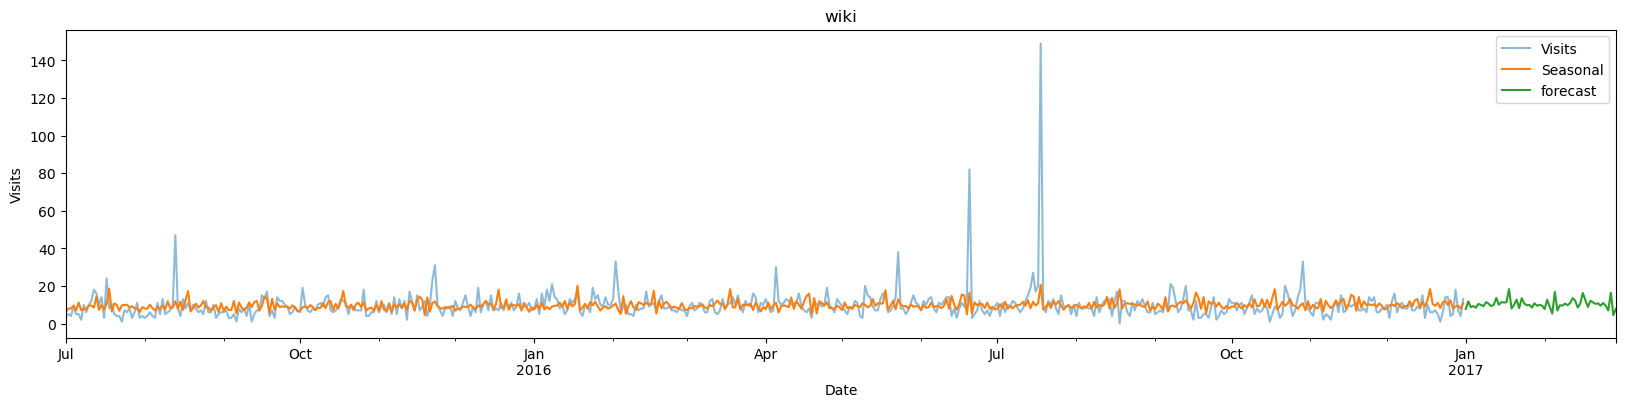

In [15]:
y = filtre['Visits'].copy()
y.index  = pd.to_datetime(y.index)
fourier = CalendarFourier(freq="M", order=20)
dp = DeterministicProcess(
    index=y.index,
    constant=True,            
    order=1,                     
    seasonal=True,               
    additional_terms=[fourier],  
    drop=True,  
)

X = dp.in_sample()

model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

start_date = X.index[-1] + pd.DateOffset(1)
end_date = start_date + pd.DateOffset(days=59)
X_fore_index = pd.date_range(start=start_date, end=end_date)

X_fore = dp.out_of_sample(steps=60, forecast_index=X_fore_index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = plt.figure(figsize=(20,4))
ax = y.plot( alpha=0.5, title="wiki", ylabel="Visits")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax = ax, label = "forecast")
y_season = y_pred
ax.legend();

In [16]:
season_error = mse(y,y_pred)
season_error

63.58562056596441

In [17]:
y_deseason = y - y_season

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


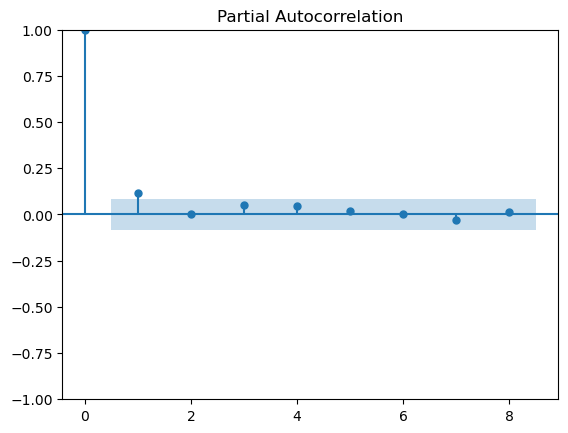

In [18]:
plot_pacf(y_deseason, lags=8);

In [19]:
X = make_lags(y_deseason, lags=1).fillna(0.0)
X_train = X.loc[:'2016-11-01',:]
X_test = X.loc['2016-11-01':,:]
y_train = y_deseason[:'2016-11-01']
y_test = y_deseason['2016-11-01':]

In [20]:
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred_train = pd.Series(model.predict(X_train), index = X_train.index)
y_pred_train = y_pred_train +  y_season[y_train.index]
y_pred_test = pd.Series(model.predict(X_test), index = X_test.index)
y_pred_test = y_pred_test  + y_season[y_test.index]
y_train = y_train +  y_season[y_train.index]
y_test = y_test + y_season[y_test.index]

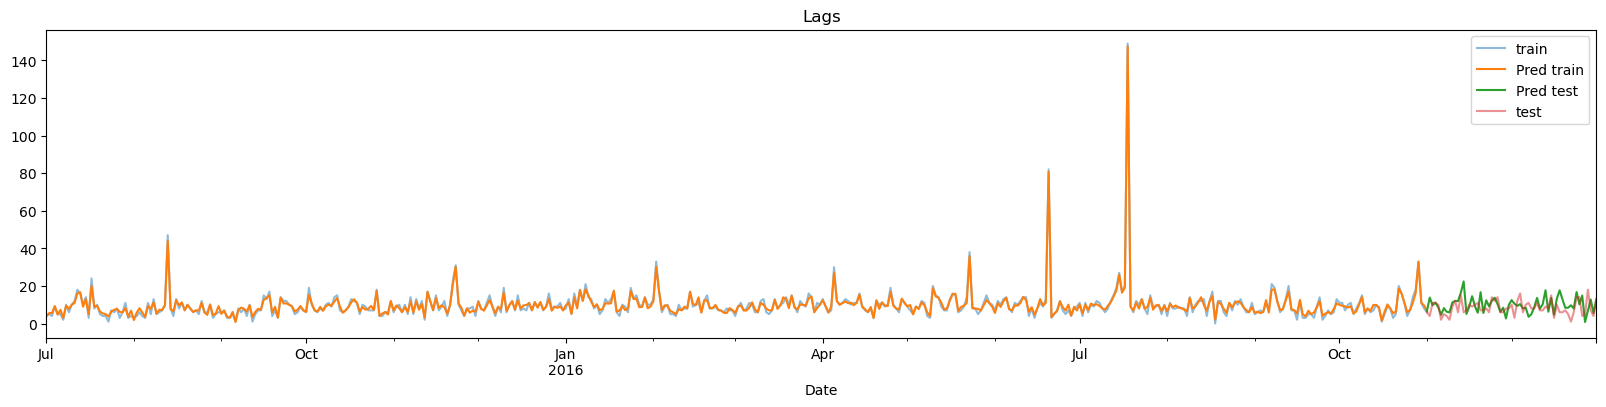

In [21]:
ax = plt.figure(figsize=(20,4))
ax = y_train.plot( alpha=0.5, title="Lags", label = "train")
ax = y_pred_train.plot(title="Lags", label = "Pred train")
ax = y_pred_test.plot(title="Lags", label = "Pred test")
ax = y_test.plot( alpha=0.5, title="Lags", label = "test")
plt.legend()

In [22]:
lag_error = mse(y_test,y_pred_test,squared = False)
lag_error

5.079373328982995

In [23]:
ax = plt.figure(figsize=(20,4))
ax = y_train['y_step_1'].plot( alpha=0.5, title="RF", label = "train")
ax = y_pred_train2['y_step_1'].plot(title="RF", label = "Pred train")
ax = y_pred_test2['y_step_1'].plot(title="RF", label = "Pred test")
ax = y_test['y_step_1'].plot( alpha=0.5, title="RF", label = "test")
plt.legend()

KeyError: 'y_step_1'

<Figure size 2000x400 with 0 Axes>

## Results Analysis
- Hybrid Linear + XGB with hyperparam tunned is the best

In [ ]:
errors = pd.DataFrame()
errors.index = ['Linar','Season','Lag','Linear+XGB','Linear+RF']
errors['MSE'] = [trend_error,season_error,lag_error,hybrid_error_XGB,hybrid_error_RF]
errors